In [2]:
from obspy import read
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Path to the .mseed file
data_directory = '../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1975-04-12HR00_evid00191.mseed' #request
mseed_file = f'{data_directory}'

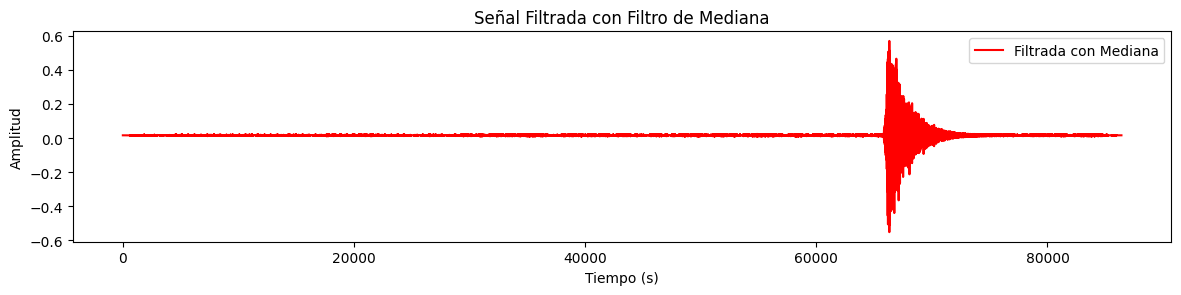

In [3]:
from scipy.signal import medfilt, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Read the mseed file
st = read(mseed_file)
tr = st[0].copy()  # Obtain the first trace

# Apply a highpass filter
minfreq = 0.5
tr.filter('highpass', freq=minfreq)

# Obtain filtered trace data
tr_times = tr.times()
tr_data = tr.data

# Min-Max normalization
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Escalado entre -1 y 1

# 1. Apply a Median Filter
tr_data_median_filtered = medfilt(tr_data_minmax, kernel_size=5) 

# Visualize the signals
plt.figure(figsize=(12, 8))

# Filtered Signal with Median
plt.subplot(3, 1,1)
plt.plot(tr_times, tr_data_median_filtered, 'r-', label='Filtrada con Mediana')
plt.title('Señal Filtrada con Filtro de Mediana')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.savefig('mediana.png')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import noisereduce as nr
sample_rate = 1 / (tr_times[1] - tr_times[0])  # Calculate sampling rate
signal_cleaned = nr.reduce_noise(y=tr_data_median_filtered, sr=sample_rate, time_mask_smooth_ms=40000)

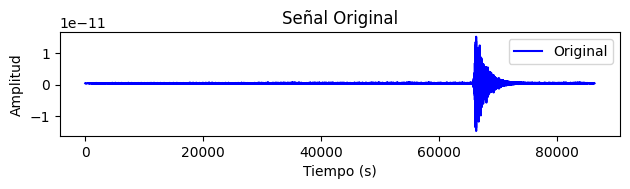

In [5]:
plt.subplot(3, 1, 1)
plt.plot(tr_times, signal_cleaned , 'b-', label='Original')
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
import ast

# Cadena a deserializar
def deserialized(data):
    # Deserializar la cadena usando ast.literal_eval
    deserialized_data = ast.literal_eval(data)
    return deserialized_data


In [7]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from .env

gemini_api_key = os.getenv("API_KEY")

genai.configure(api_key=gemini_api_key)
model = genai.GenerativeModel("CosmicQuakesmodelV2")
chat_session = model.start_chat(
    history=[
    ]
)

In [8]:
# Create the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="tunedModels/cosmicquakesmodelv2-9lu1tmy3mfet",
  generation_config=generation_config,
  # safety_settings = Adjust safety settings
  # See https://ai.google.dev/gemini-api/docs/safety-settings
)


In [9]:
file = "https://drive.google.com/file/d/1HMX9xdVNWBflJanJxRyzxo6zXm6wj3m3/view?usp=drive_link"

In [13]:
prompt = """
How many earthquakes are in the graph? Keep in mind that earthquakes are the signals contained within the blue boxes.
Image URL: https://drive.google.com/uc?export=view&id=1tvUVJIFd5jmmaxItfLNXyyR6Y1pki-XO
Respond with numbers only.
"""

InvalidArgument: 400 * GenerateContentRequest.model: unexpected model name format


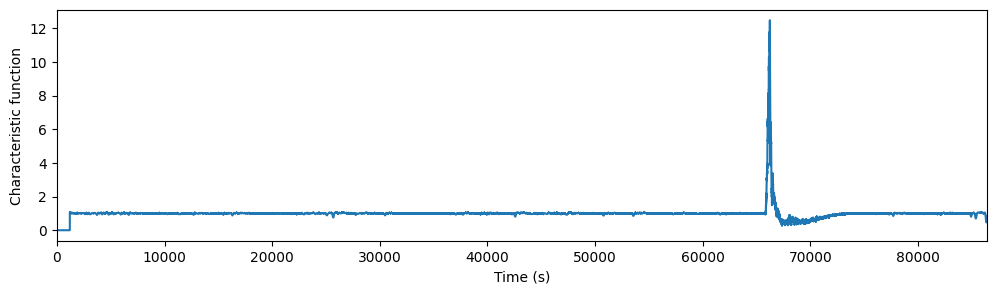

In [14]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Initialize variables
confirmation = "no"  # You want to set confirmation to "no" to begin the while loop
i = 0

# Sampling frequency of the trace
df = tr.stats.sampling_rate

while confirmation != "yes":
    if i == 0:
        # Default STA/LTA window lengths
        sta_len = 60  # Short-term window in seconds
        lta_len = 1200  # Long-term window in seconds
    else:
        # Use the updated window lengths from the user response
        sta_len, lta_len = tupla

    # Run Obspy's STA/LTA to obtain a characteristic function
    cft = classic_sta_lta(signal_cleaned, int(sta_len * df), int(lta_len * df))

    # Define the minimum event duration (in seconds)
    min_duration = 420  # Adjust as per requirements
    # Convert minimum duration to samples
    min_duration_samples = int(min_duration * df)

    # Plot the characteristic function
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times, cft)
    ax.set_xlim([min(tr_times), max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')
    plt.savefig('caracteristica.png')  # Save the plot as an image

    # Send the analysis request (assuming chat_session.send_message() is valid)
    response = chat_session.send_message(prompt)
    # Deserialize the response
    l_response = deserialized(response)
    tupla = l_response[0]  # Extract STA/LTA window lengths
    confirmation = l_response[1]  # Check if the confirmation is "yes" or "no"
    
    i += 1  # Increment the loop counter


Iteración 0: Probando con thr_on=12, thr_off=1
Iteración 1: Probando con thr_on=10, thr_off=1
Iteración 2: Probando con thr_on=6, thr_off=1
Se encontraron eventos que cumplen la condición en la iteración 2 con thr_on=6 y thr_off=1.


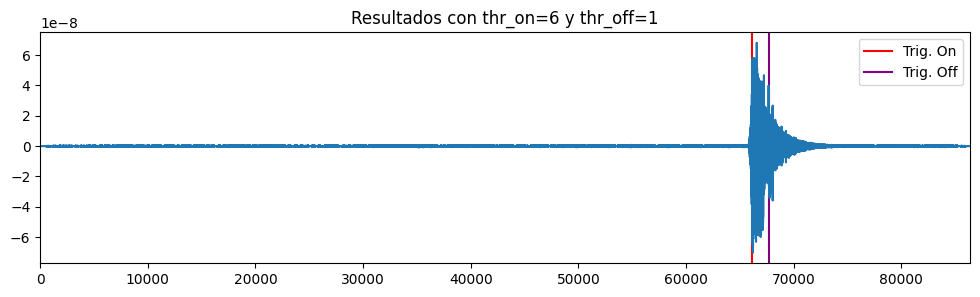

In [23]:
import numpy as np
import matplotlib.pyplot as plt

l_threshold_on = [12,10,6,5,4,1.8,1.5,1.1]  # Activation thresholds list
l_threshold_off = [1,1,1,1,1,1,1,1]  # Deactivation thresholds list

filtered_on_off = []  # Initialize the list that will store the filtered events
idx = 0  # Initialize the index for the thresholds lists

# While loop that execute until a non-empty list of events is found
while len(filtered_on_off) == 0 and idx < len(l_threshold_on) :
    thr_on = l_threshold_on[idx]  # Obtain the current activation threshold
    thr_off = l_threshold_off[idx]  # Obtain the current deactivation threshold
    
    print(f"Iteración {idx}: Probando con thr_on={thr_on}, thr_off={thr_off}")
    
    # Obtain the triggers using the current thresholds
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    
    # Filter the events that last less than the minimum time
    filtered_on_off = []
    for triggers in on_off:
        if (triggers[1] - triggers[0]) >= min_duration_samples:
            filtered_on_off.append(triggers)
    
    # Convert the filtered list back to a NumPy array
    filtered_on_off = np.array(filtered_on_off)

    # Increase the index to test the next set of thresholds in case no events were found
    idx += 1

# If events were found, plot them
if len(filtered_on_off) > 0:
    print(f"Se encontraron eventos que cumplen la condición en la iteración {idx-1} con thr_on={l_threshold_on[idx-1]} y thr_off={l_threshold_off[idx-1]}.")

    # Plot on and off triggers (only the filtered ones)
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    
    for i in np.arange(0, len(filtered_on_off)):
        triggers = filtered_on_off[i]
        ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On' if i == 0 else "")
        ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off' if i == 0 else "")
    
    # Plot seismogram
    ax.plot(tr_times, tr_data)
    ax.set_xlim([min(tr_times), max(tr_times)])
    
    # Handle legend without duplicates
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.title(f"Resultados con thr_on={l_threshold_on[idx-1]} y thr_off={l_threshold_off[idx-1]}")
    plt.show()
else:
    print("No se encontraron eventos que cumplan la duración mínima en ninguno de los umbrales.")

In [4]:
filtered_on_off
filtered_on_off = np.array(filtered_on_off)
filtered_on_off = filtered_on_off / df
filtered_on_off #end point

NameError: name 'filtered_on_off' is not defined